После удаления выбросов в WVHT: 61631 строк
После удаления выбросов в WSPD: 60959 строк
После удаления выбросов в GST: 60959 строк
Линейная регрессия:
RMSE: 0.081
MAE: 0.058
R²: 0.981
RMSE (WVHT>2): 0.137
MAE (WVHT>2): 0.101
R² (WVHT>2): 0.934


[I 2025-07-08 12:06:57,163] A new study created in memory with name: no-name-adad964e-a169-4f75-9e71-1dd984901e14



RandomForest:
RMSE: 0.104
MAE: 0.075
R²: 0.968
RMSE (WVHT>2): 0.163
MAE (WVHT>2): 0.119
R² (WVHT>2): 0.907


[I 2025-07-08 12:07:02,327] Trial 0 finished with value: 0.07886522739009756 and parameters: {'iterations': 374, 'depth': 8, 'learning_rate': 0.268086469914278}. Best is trial 0 with value: 0.07886522739009756.
[I 2025-07-08 12:07:03,172] Trial 1 finished with value: 0.08405856256586926 and parameters: {'iterations': 150, 'depth': 4, 'learning_rate': 0.21506046606812718}. Best is trial 0 with value: 0.07886522739009756.
[I 2025-07-08 12:07:11,154] Trial 2 finished with value: 0.0787563907360355 and parameters: {'iterations': 415, 'depth': 9, 'learning_rate': 0.06320911459070905}. Best is trial 2 with value: 0.0787563907360355.
[I 2025-07-08 12:07:16,617] Trial 3 finished with value: 0.07731704403378117 and parameters: {'iterations': 408, 'depth': 8, 'learning_rate': 0.10567150163509793}. Best is trial 3 with value: 0.07731704403378117.
[I 2025-07-08 12:07:18,525] Trial 4 finished with value: 0.08849516480461955 and parameters: {'iterations': 181, 'depth': 7, 'learning_rate': 0.06046511


CatBoost (после оптимизации Optuna):
Лучшие параметры: {'iterations': 415, 'depth': 6, 'learning_rate': 0.20467190285938455}
RMSE: 0.076
MAE: 0.055
R²: 0.983
RMSE (WVHT>2): 0.119
MAE (WVHT>2): 0.088
R² (WVHT>2): 0.950

Permutation Importance (CatBoost):
      Feature  Importance
8   WVHT_lag1    0.792054
0         APD    0.579566
5    APD_lag1    0.276853
9   WVHT_lag2    0.164575
10  WVHT_lag3    0.032753
4     GST_APD    0.027267
6    APD_lag2    0.020160
1    WSPD_GST    0.011486
7    APD_lag3    0.005521
3    WSPD_APD    0.004471
2     APD_DPD    0.004404


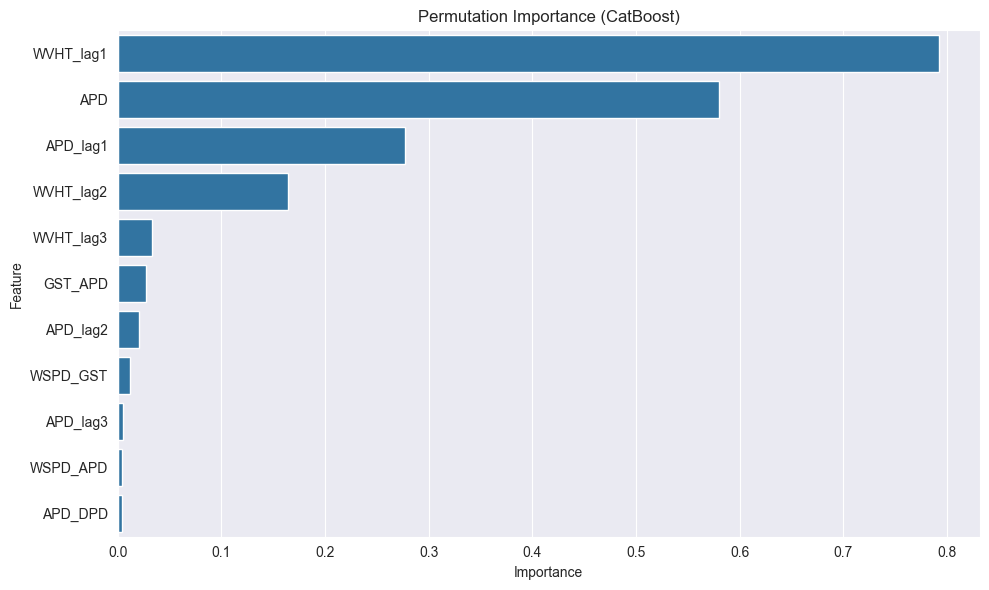


Важность признаков (CatBoost):
      Feature  Importance
8   WVHT_lag1   43.733191
9   WVHT_lag2   25.403762
10  WVHT_lag3   16.056802
0         APD    5.155012
5    APD_lag1    3.037025
4     GST_APD    2.670743
3    WSPD_APD    1.158732
2     APD_DPD    0.885066
6    APD_lag2    0.814265
7    APD_lag3    0.687116
1    WSPD_GST    0.398287

Важность признаков (RandomForest):
      Feature  Importance
8   WVHT_lag1    0.972701
9   WVHT_lag2    0.012670
4     GST_APD    0.003353
10  WVHT_lag3    0.002884
0         APD    0.002639
3    WSPD_APD    0.001558
2     APD_DPD    0.001415
5    APD_lag1    0.000976
6    APD_lag2    0.000654
7    APD_lag3    0.000579
1    WSPD_GST    0.000570


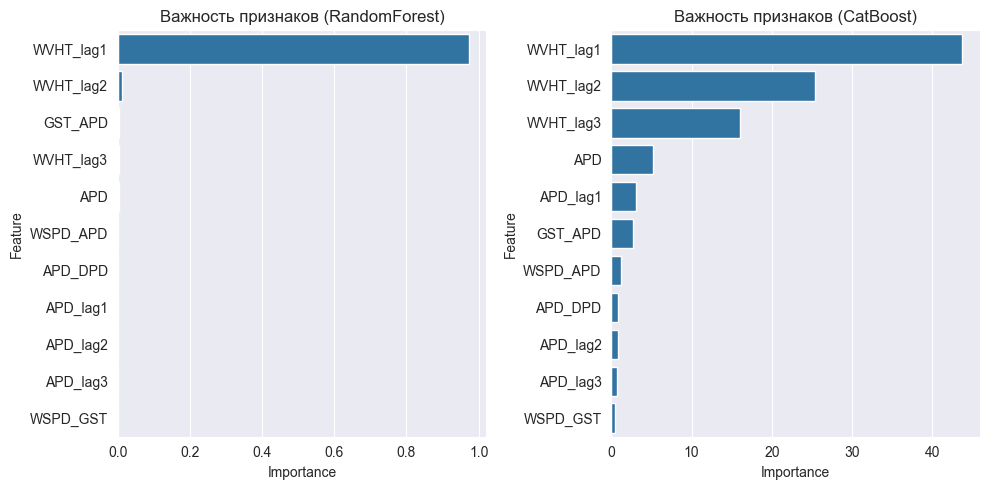

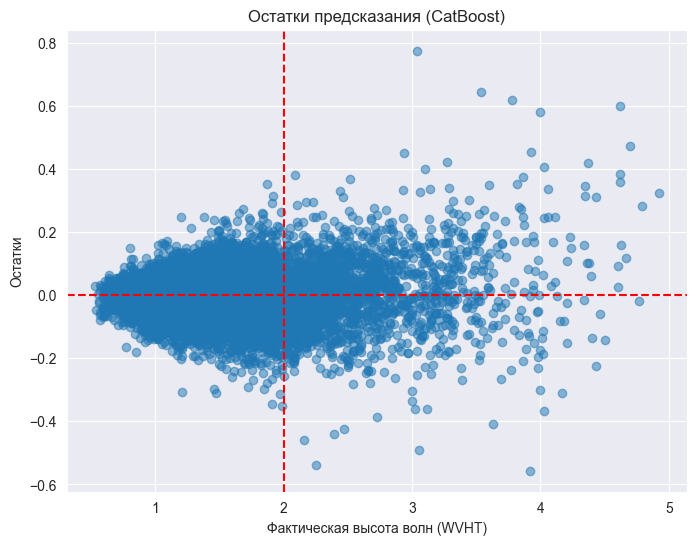

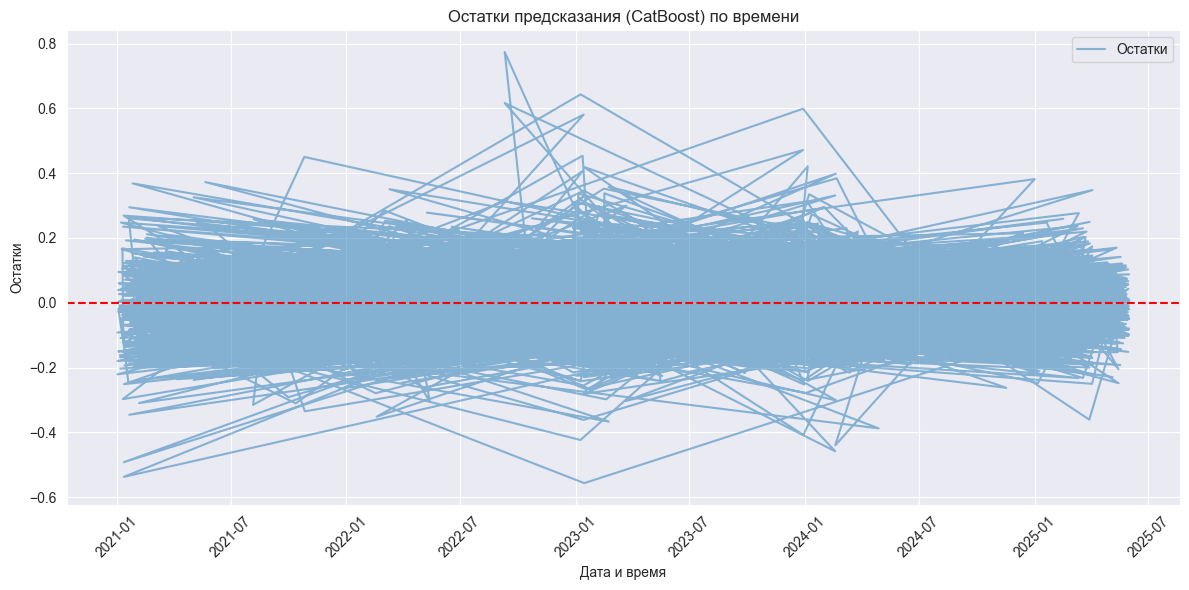

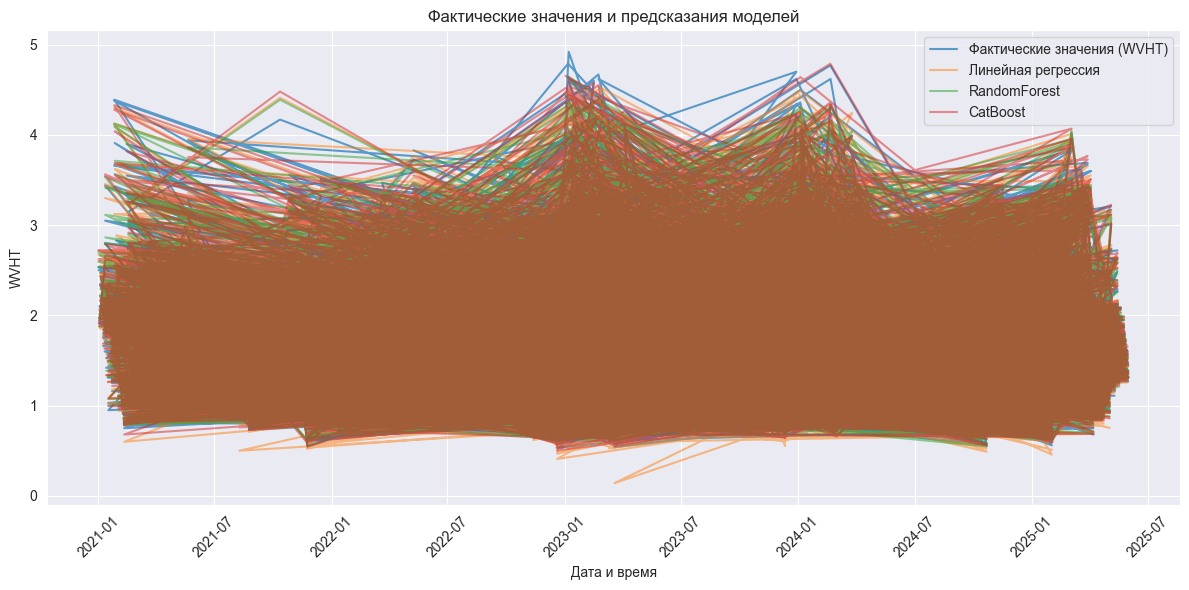


Сравнение моделей:
               Модель      RMSE       MAE        R²  RMSE (WVHT>2)  \
0  Линейная регрессия  0.080807  0.057924  0.980595       0.136883   
1        RandomForest  0.104384  0.074989  0.967620       0.162550   
2            CatBoost  0.075728  0.055108  0.982958       0.119436   

   MAE (WVHT>2)  R² (WVHT>2)  
0      0.101372     0.933845  
1      0.119485     0.906710  
2      0.088384     0.949635  


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor
import optuna
import joblib

# Чтение данных
files = ['data2021.txt', 'data2022.txt', 'data2023.txt', 'data2024.txt', 'data2025.txt']
dataframes = []
for file in files:
    df = pd.read_csv(file, sep=r'\s+', skiprows=2,
                     names=['YY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'WSPD', 'GST', 'WVHT',
                            'DPD', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'TIDE'])
    dataframes.append(df)
data = pd.concat(dataframes, ignore_index=True)

# Преобразование типов и замена пропусков
special_values = [99.0, 99.00, 999.0, 9999.0]
numeric_columns = ['WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'TIDE']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].replace(special_values, np.nan)

# Удаление строк с пропусками в WVHT
data_cleaned = data.dropna(subset=['WVHT'])

# Удаление VIS и TIDE
data_cleaned = data_cleaned.drop(columns=['VIS', 'TIDE'])

# Создание столбца datetime для временного разделения
data_cleaned['datetime'] = pd.to_datetime(data_cleaned[['YY', 'MM', 'DD', 'hh', 'mm']].rename(
    columns={'YY': 'year', 'MM': 'month', 'DD': 'day', 'hh': 'hour', 'mm': 'minute'}))

# Сортировка по времени
data_cleaned = data_cleaned.sort_values('datetime')

# Новые признаки (только ключевые)
data_cleaned['WSPD_GST'] = data_cleaned['WSPD'] * data_cleaned['GST']
data_cleaned['APD_DPD'] = data_cleaned['APD'] * data_cleaned['DPD']
data_cleaned['WSPD_APD'] = data_cleaned['WSPD'] * data_cleaned['APD']
data_cleaned['GST_APD'] = data_cleaned['GST'] * data_cleaned['APD']

# Обработка выбросов с IQR=5.0
def remove_outliers(df, column, iqr_factor=5.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in ['WVHT', 'WSPD', 'GST']:
    data_cleaned = remove_outliers(data_cleaned, col, iqr_factor=5.0)
    print(f"После удаления выбросов в {col}: {len(data_cleaned)} строк")

# Создание лаговых признаков до разделения данных
lag_columns = ['WSPD', 'GST', 'APD', 'WVHT']
for col in lag_columns:
    for lag in [1, 2, 3]:
        data_cleaned[f'{col}_lag{lag}'] = data_cleaned[col].shift(lag)

# Удаление ненужных столбцов
data_cleaned = data_cleaned.drop(columns=['YY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP'])

# Стратифицированное разделение данных (80% train, 20% test)
# Примечание: stratify не требуется без классификации, но оставлено для консистентности
train_data, test_data = train_test_split(data_cleaned, test_size=0.2, random_state=42)
train_data = train_data.dropna()
test_data = test_data.dropna()
datetime_test = test_data['datetime']

# Выбор признаков (11 признаков, исключены низкой важности)
features = ['APD', 'WSPD_GST', 'APD_DPD', 'WSPD_APD', 'GST_APD', 'APD_lag1', 'APD_lag2', 'APD_lag3', 'WVHT_lag1', 'WVHT_lag2', 'WVHT_lag3']
target = 'WVHT'

# Обновление выборок
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Интерполяция пропусков
X_train = X_train.infer_objects(copy=False).interpolate(method='linear', limit_direction='forward').fillna(X_train.mean())
X_test = X_test.infer_objects(copy=False).interpolate(method='linear', limit_direction='forward').fillna(X_test.mean())

# Нормализация для линейной регрессии
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Копии для деревьев
X_train_tree = X_train.copy()
X_test_tree = X_test.copy()

# 1. Линейная регрессия
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)
mask = y_test > 2
lr_mae_high = mean_absolute_error(y_test[mask], lr_pred[mask]) if mask.sum() > 0 else np.nan
lr_rmse_high = np.sqrt(mean_squared_error(y_test[mask], lr_pred[mask])) if mask.sum() > 0 else np.nan
lr_r2_high = r2_score(y_test[mask], lr_pred[mask]) if mask.sum() > 0 else np.nan
print("Линейная регрессия:")
print(f"RMSE: {lr_rmse:.3f}")
print(f"MAE: {lr_mae:.3f}")
print(f"R²: {lr_r2:.3f}")
print(f"RMSE (WVHT>2): {lr_rmse_high:.3f}")
print(f"MAE (WVHT>2): {lr_mae_high:.3f}")
print(f"R² (WVHT>2): {lr_r2_high:.3f}")

# 2. RandomForest с улучшенными параметрами
rf_model = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
sample_weights = np.where(y_train > 2, 5, 1)
rf_model.fit(X_train_tree, y_train, sample_weight=sample_weights)
rf_pred = rf_model.predict(X_test_tree)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae_high = mean_absolute_error(y_test[mask], rf_pred[mask]) if mask.sum() > 0 else np.nan
rf_rmse_high = np.sqrt(mean_squared_error(y_test[mask], rf_pred[mask])) if mask.sum() > 0 else np.nan
rf_r2_high = r2_score(y_test[mask], rf_pred[mask]) if mask.sum() > 0 else np.nan
print("\nRandomForest:")
print(f"RMSE: {rf_rmse:.3f}")
print(f"MAE: {rf_mae:.3f}")
print(f"R²: {rf_r2:.3f}")
print(f"RMSE (WVHT>2): {rf_rmse_high:.3f}")
print(f"MAE (WVHT>2): {rf_mae_high:.3f}")
print(f"R² (WVHT>2): {rf_r2_high:.3f}")

# 3. CatBoost с Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_seed': 42,
        'verbose': 0
    }
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []
    for train_idx, valid_idx in tscv.split(X_train_tree):
        X_t, X_v = X_train_tree.iloc[train_idx], X_train_tree.iloc[valid_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        sample_weights = np.where(y_t > 2, 5, 1)
        model = CatBoostRegressor(**params)
        model.fit(X_t, y_t, sample_weight=sample_weights)
        pred = model.predict(X_v)
        rmse = np.sqrt(mean_squared_error(y_v, pred))
        rmse_scores.append(rmse)
    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_params = study.best_params
best_cat_model = CatBoostRegressor(**best_params, verbose=0)
sample_weights = np.where(y_train > 2, 5, 1)
best_cat_model.fit(X_train_tree, y_train, sample_weight=sample_weights)
best_cat_pred = best_cat_model.predict(X_test_tree)
best_cat_rmse = np.sqrt(mean_squared_error(y_test, best_cat_pred))
best_cat_mae = mean_absolute_error(y_test, best_cat_pred)
best_cat_r2 = r2_score(y_test, best_cat_pred)
best_cat_mae_high = mean_absolute_error(y_test[mask], best_cat_pred[mask]) if mask.sum() > 0 else np.nan
best_cat_rmse_high = np.sqrt(mean_squared_error(y_test[mask], best_cat_pred[mask])) if mask.sum() > 0 else np.nan
best_cat_r2_high = r2_score(y_test[mask], best_cat_pred[mask]) if mask.sum() > 0 else np.nan
print("\nCatBoost (после оптимизации Optuna):")
print(f"Лучшие параметры: {best_params}")
print(f"RMSE: {best_cat_rmse:.3f}")
print(f"MAE: {best_cat_mae:.3f}")
print(f"R²: {best_cat_r2:.3f}")
print(f"RMSE (WVHT>2): {best_cat_rmse_high:.3f}")
print(f"MAE (WVHT>2): {best_cat_mae_high:.3f}")
print(f"R² (WVHT>2): {best_cat_r2_high:.3f}")

# Сохранение моделей
joblib.dump(lr_model, 'lr_model.pkl')
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(best_cat_model, 'catboost_model.pkl')

# Permutation Importance для CatBoost
perm_importance = permutation_importance(best_cat_model, X_test_tree, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({'Feature': features, 'Importance': perm_importance.importances_mean})
perm_df = perm_df.sort_values(by='Importance', ascending=False)
print("\nPermutation Importance (CatBoost):")
print(perm_df)

# Визуализация Permutation Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_df)
plt.title('Permutation Importance (CatBoost)')
plt.tight_layout()
plt.show()

# Важность признаков для CatBoost
cat_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_cat_model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)
print("\nВажность признаков (CatBoost):")
print(cat_importance)

# Важность признаков для RandomForest
rf_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nВажность признаков (RandomForest):")
print(rf_importance)

# Визуализация важности признаков
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=rf_importance)
plt.title('Важность признаков (RandomForest)')
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=cat_importance)
plt.title('Важность признаков (CatBoost)')
plt.tight_layout()
plt.show()

# Анализ остатков для CatBoost
residuals = y_test - best_cat_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Фактическая высота волн (WVHT)')
plt.ylabel('Остатки')
plt.title('Остатки предсказания (CatBoost)')
plt.axvline(x=2, color='r', linestyle='--')
plt.show()

# График ошибок по времени
plt.figure(figsize=(12, 6))
plt.plot(datetime_test, residuals, alpha=0.5, label='Остатки')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Дата и время')
plt.ylabel('Остатки')
plt.title('Остатки предсказания (CatBoost) по времени')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# График предсказаний по времени
plt.figure(figsize=(12, 6))
plt.plot(datetime_test, y_test, label='Фактические значения (WVHT)', alpha=0.7)
plt.plot(datetime_test, lr_pred, label='Линейная регрессия', alpha=0.5)
plt.plot(datetime_test, rf_pred, label='RandomForest', alpha=0.5)
plt.plot(datetime_test, best_cat_pred, label='CatBoost', alpha=0.5)
plt.xlabel('Дата и время')
plt.ylabel('WVHT')
plt.title('Фактические значения и предсказания моделей')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Сравнение моделей
results = pd.DataFrame({
    'Модель': ['Линейная регрессия', 'RandomForest', 'CatBoost'],
    'RMSE': [lr_rmse, rf_rmse, best_cat_rmse],
    'MAE': [lr_mae, rf_mae, best_cat_mae],
    'R²': [lr_r2, rf_r2, best_cat_r2],
    'RMSE (WVHT>2)': [lr_rmse_high, rf_rmse_high, best_cat_rmse_high],
    'MAE (WVHT>2)': [lr_mae_high, rf_mae_high, best_cat_mae_high],
    'R² (WVHT>2)': [lr_r2_high, rf_r2_high, best_cat_r2_high]
})
print("\nСравнение моделей:")
print(results)

# Сохранение результатов
data_cleaned.to_csv('final_data_with_features_iqr50_lags3.csv', index=False)